## FAVORITA STORES SALE

### HYPOTHESIS
Null Hypothesis: Promotions do not affect sales

Alternative hypothesis: Promotions increases sales

## Data Preparation

### Questions

The questions below are to be answered. Do note that, you are free to draw more hypothesis from the data.

1) Is the train dataset complete (has all the required dates)?

2) Which dates have the lowest and highest sales for each year?

3) Did the earthquake impact sales?

4) Are certain groups of stores selling more products? (Cluster, city, state, type)

5) Are sales affected by promotions, oil prices and holidays?

6) What analysis can we get from the date and its extractable features?

7) What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

In [1]:
# Import the necessary libraries

import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load environment variables from .env file into a dictionary
db_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = db_variables.get("SERVER")
database = db_variables.get("DATABASE")
username = db_variables.get("USER")
password = db_variables.get("PASSWORD")

connection = f"DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [3]:
# Connect to the tables in the db

conn = pyodbc.connect(connection)

query = "SELECT * FROM dbo.oil"
query1 = "SELECT * FROM dbo.holidays_events"
query2 = "SELECT * FROM dbo.stores"

### 1st Dataset

In [4]:
# dbo.oil

oil = pd.read_sql(query,conn)
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [5]:
# dbo.holidays_events

holidays_events = pd.read_sql(query1,conn)
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
# dbo.stores

stores = pd.read_sql(query2,conn)
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
df = pd.merge(holidays_events,oil, on='date', how='left')
df.head()

,date,type,locale,locale_name,description,transferred,dcoilwtico
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,NaN
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,NaN
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,NaN
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,NaN
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,NaN


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
 6   dcoilwtico   182 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float64(1), object(4)
memory usage: 16.9+ KB


In [38]:
df['date'] = pd.to_datetime(df['date'])

In [9]:
df.isna().sum()

date             0
type             0
locale           0
locale_name      0
description      0
transferred      0
dcoilwtico     168
dtype: int64

### TEST dataset

In [10]:
# sample_submission

df_sample = pd.read_csv('sample_submission.csv')
df_sample.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [11]:
test = pd.read_csv('test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [13]:
test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

### 3rd Dataset

In [14]:
df_trx = pd.read_csv("transactions.csv")
df_trx.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [15]:
df_train = pd.read_csv("E:\\AZUBI CAREER ACCELERATOR\\Data Analytics\\PROJECTS\\Project 3\\LP3 Regression Project\\store-sales-forecasting\\train.csv")
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [25]:
df_trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [27]:

df1 = pd.concat([df_train,df_trx], axis=0)
df1.head()


,id,date,store_nbr,family,sales,onpromotion,transactions
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,NaN
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,NaN
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,NaN
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,NaN
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,NaN


In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3084376 entries, 0 to 83487
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            float64       
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   transactions  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 188.3+ MB


In [30]:
df1['date'] = pd.to_datetime(df1['date'])

In [32]:
df2 = pd.merge(df1,stores, on='store_nbr')
df2.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,NaN,Quito,Pichincha,D,13
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,NaN,Quito,Pichincha,D,13
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,NaN,Quito,Pichincha,D,13
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,NaN,Quito,Pichincha,D,13
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,NaN,Quito,Pichincha,D,13


In [33]:
df2.isna().sum()

id                83488
date                  0
store_nbr             0
family            83488
sales             83488
onpromotion       83488
transactions    3000888
city                  0
state                 0
type                  0
cluster               0
dtype: int64

In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084376 entries, 0 to 3084375
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            float64       
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   transactions  float64       
 7   city          object        
 8   state         object        
 9   type          object        
 10  cluster       int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 258.9+ MB


In [37]:
df.head(3)

,date,type,locale,locale_name,description,transferred,dcoilwtico
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,NaN
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,NaN
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,NaN


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
 6   dcoilwtico   182 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float64(1), object(4)
memory usage: 16.9+ KB


### EDA

In [42]:
df.head(2)

,date,type,locale,locale_name,description,transferred,dcoilwtico
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,NaN
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,NaN


In [44]:
df2.head(2)

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,NaN,Quito,Pichincha,D,13
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,NaN,Quito,Pichincha,D,13


In [50]:
data = pd.concat([df2,df],join='outer',ignore_index=True)
data.head(3)

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,locale,locale_name,description,transferred,dcoilwtico
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,NaN,NaN,NaN,NaN
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,NaN,NaN,NaN,NaN
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,NaN,NaN,NaN,NaN


In [51]:
data.shape

(3084726, 16)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084726 entries, 0 to 3084725
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            float64       
 1   date          datetime64[ns]
 2   store_nbr     float64       
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   transactions  float64       
 7   city          object        
 8   state         object        
 9   type          object        
 10  cluster       float64       
 11  locale        object        
 12  locale_name   object        
 13  description   object        
 14  transferred   object        
 15  dcoilwtico    float64       
dtypes: datetime64[ns](1), float64(7), object(8)
memory usage: 376.6+ MB


In [53]:
data.isna().sum()

id                83838
date                  0
store_nbr           350
family            83838
sales             83838
onpromotion       83838
transactions    3001238
city                350
state               350
type                  0
cluster             350
locale          3084376
locale_name     3084376
description     3084376
transferred     3084376
dcoilwtico      3084544
dtype: int64

In [54]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
id,3000888.0,1500443.5,0.0,750221.75,1500443.5,2250665.25,3000887.0,866281.891642
date,3084726,2015-04-25 01:32:48.267393024,2012-03-02 00:00:00,2014-02-27 00:00:00,2015-04-26 00:00:00,2016-06-20 00:00:00,2017-12-26 00:00:00,NaN
store_nbr,3084376.0,27.484821,1.0,14.0,27.0,41.0,54.0,15.586657
sales,3000888.0,357.775749,0.0,0.0,11.0,195.84725,124717.0,1101.997721
onpromotion,3000888.0,2.60277,0.0,0.0,0.0,0.0,741.0,12.218882
transactions,83488.0,1694.602158,5.0,1046.0,1393.0,2079.0,8359.0,963.286644
cluster,3084376.0,8.482895,1.0,4.0,9.0,13.0,17.0,4.651777
dcoilwtico,182.0,65.269945,27.959999,44.895,51.994999,95.25,107.949997,25.525348


<Figure size 1800x1000 with 0 Axes>

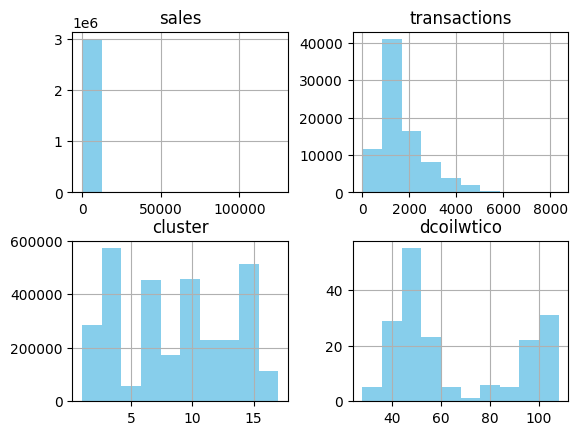

In [59]:
plt.figure(figsize=(18,10))
data.hist(column=['sales','transactions','cluster','dcoilwtico'],color='skyblue')
plt.show();

In [60]:
data.corr(numeric_only=True)

,id,store_nbr,sales,onpromotion,transactions,cluster,dcoilwtico
id,1.000000,0.000301,0.085784,0.206260,NaN,-0.000044,NaN
store_nbr,0.000301,1.000000,0.041196,0.007286,0.189311,-0.059817,NaN
sales,0.085784,0.041196,1.000000,0.427923,NaN,0.038525,NaN
onpromotion,0.206260,0.007286,0.427923,1.000000,NaN,0.005667,NaN
transactions,NaN,0.189311,NaN,NaN,1.000000,0.196014,NaN
cluster,-0.000044,-0.059817,0.038525,0.005667,0.196014,1.000000,NaN
dcoilwtico,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [61]:
categorical_col = data.select_dtypes(include='object').columns
categorical_col

Index(['family', 'city', 'state', 'type', 'locale', 'locale_name',
       'description', 'transferred'],
      dtype='object')

In [62]:
numerical_col = data.select_dtypes(include='number').columns
numerical_col

Index(['id', 'store_nbr', 'sales', 'onpromotion', 'transactions', 'cluster',
       'dcoilwtico'],
      dtype='object')

In [63]:
data['date'] = pd.to_datetime(data['date'])

### 1)Is the train dataset complete (has all the required dates)?

In [64]:
data['date'] = pd.to_datetime(data['date'])
min_date = data['date'].min()
max_date = data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)
 
missing_dates = expected_dates[~expected_dates.isin(data['date'])]
 
if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2012-03-03', '2012-03-04', '2012-03-05', '2012-03-06',
               '2012-03-07', '2012-03-08', '2012-03-09', '2012-03-10',
               '2012-03-11', '2012-03-12',
               ...
               '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
               '2017-12-15', '2017-12-16', '2017-12-17', '2017-12-18',
               '2017-12-19', '2017-12-20'],
              dtype='datetime64[ns]', length=382, freq=None)


In [65]:
test['date'] = pd.to_datetime(test['date'])
min_date = test['date'].min()
max_date = test['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)
 
missing_dates = expected_dates[~expected_dates.isin(data['date'])]
 
if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
               '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-25', '2017-08-26', '2017-08-27', '2017-08-28',
               '2017-08-29', '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', freq=None)


### 2) Which dates have the lowest and highest sales for each year?

In [83]:
#Extract the year from the 'date' column
data['year'] = data['date'].dt.year



#Group by year and find the dates with the lowest and highest sales
data = data.dropna(subset=['year'])

# Group by year and find the dates with the lowest and highest sales
min_dates = data.loc[data.groupby('year')['sales'].idxmin(), ['year', 'date', 'sales']]
max_dates = data.loc[data.groupby('year')['sales'].idxmax(), ['year', 'date', 'sales']]

# Display the results
print("Dates with the Lowest Sales for Each Year:")
print(min_dates)

print("\nDates with the Highest Sales for Each Year:")
print(max_dates)

KeyError: '[nan] not in index'

### 3) Did the earthquake impact sales?

In [70]:
quake_sales = data.groupby('year')['sales'].sum()
quake_sales

year
2012    0.000000e+00
2013    1.404190e+08
2014    2.094742e+08
2015    2.408801e+08
2016    2.886545e+08
2017    1.942171e+08
Name: sales, dtype: float64

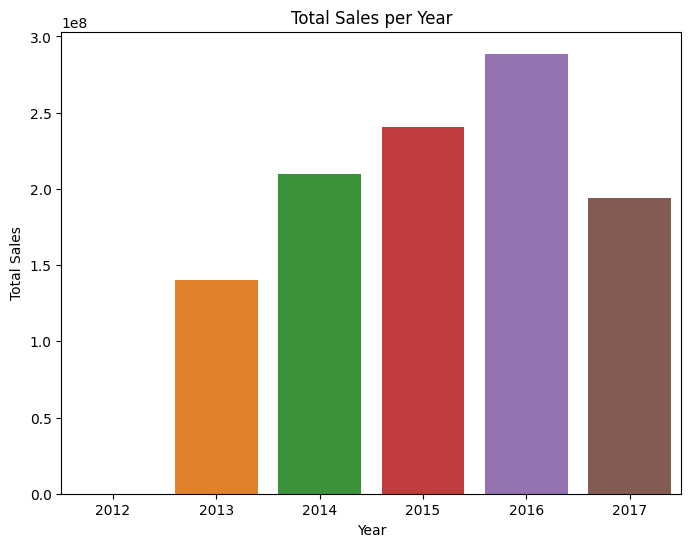

In [81]:
plt.figure(figsize=(8,6))

sns.barplot(x=quake_sales.index, y=quake_sales.values)
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales per Year')
plt.show()

### 4) Are certain groups of stores selling more products? (Cluster, city, state, type)

In [93]:
result = (
    data.groupby(['city','type'])['sales']
    .count()
    .sort_values(ascending=False)
    .head()
    
)

print(result)


city       type
Quito      D       389004
           A       333432
           B       166716
Guayaquil  C       111144
Latacunga  C       111144
Name: sales, dtype: int64


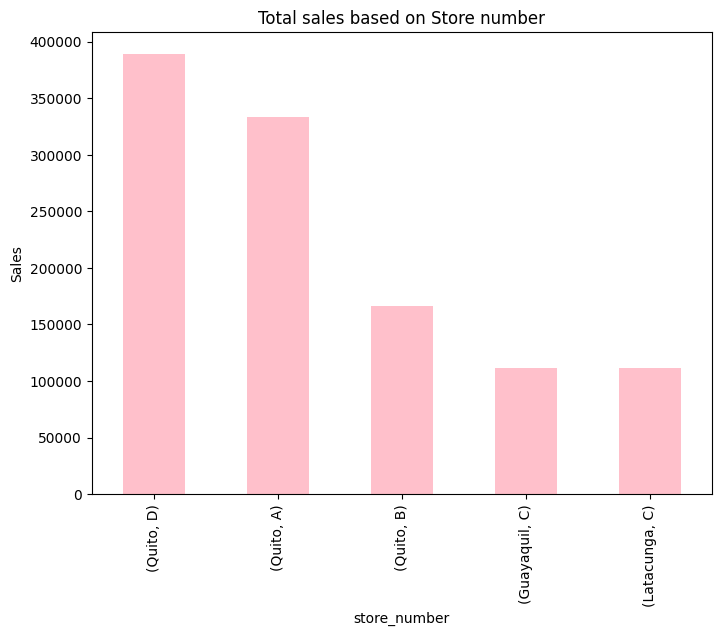

In [94]:
plt.figure(figsize=(8,6))
result.plot(kind='bar', color='pink')
plt.xlabel('store_number')
plt.ylabel('Sales')
plt.title('Total sales based on Store number')
plt.show();


### 5) Are sales affected by promotions, oil prices and holidays?

In [95]:
#data['Year'] = data['date'].dt.year

data.head(3)

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,locale,locale_name,description,transferred,dcoilwtico,year
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,NaN,NaN,NaN,NaN,2013
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,NaN,NaN,NaN,NaN,2013
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,NaN,Quito,Pichincha,D,13.0,NaN,NaN,NaN,NaN,NaN,2013


In [96]:
data['type'].unique()

array(['D', 'C', 'B', 'E', 'A', 'Holiday', 'Transfer', 'Additional',
       'Bridge', 'Work Day', 'Event'], dtype=object)

In [106]:

# Assuming 'type', 'onpromotion', and 'sales' are columns in your DataFrame
variables = data[(data['type'] == 'Holiday') & (data['onpromotion'] >= 1)]

# Group by the conditions and calculate the sum of 'sales' for each group
data.groupby(variables)['sales'].sum()

# Display the results


ValueError: Grouper for '<class 'pandas.core.frame.DataFrame'>' not 1-dimensional

In [ ]:
T_promos = (
    data.groupby(['onpromotions'])['sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .reset_index()  # Reset index to make it a DataFrame
)



T_promos.plot(kind='bar', color='skyblue')



KeyError: 'onpromotions'


6) What analysis can we get from the date and its extractable features?


In [ ]:
date = data.groupby('year')['onpromotion'].sum()
date

: 

In [ ]:

# Make sure the 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Create a time series plot
fig = px.line(data_frame=data, x='date', y='sales', title='Time Series Plot with Time Adjustments')

# Show the plot
fig.show()


: 